## Summary

The analysis on the marketing campaign dataset, key results highlighted include the effectiveness of various marketing strategies, the impact of different features on campaign success, and the comparative performance of machine learning models. The analysis demonstrated that certain campaign types and customer demographics significantly influenced campaign outcomes. Moreover, machine learning models like RandomForest and XGBoost showed promising results in predicting campaign effectiveness, with hyperparameter tuning further enhancing their performance. These insights are critical for optimizing future marketing strategies.

## Introduction

The dataset used in this analysis is sourced from Kaggle, featuring 35 variables and a substantial volume of data with 72,612 rows. It includes details on marketing campaigns, such as impressions, clicks, and landing page data. An initial exploration of the data was performed using Python libraries like Pandas, Seaborn, and Altair for data manipulation and visualization. This preliminary analysis aimed to understand the dataset's structure and identify any data cleaning or preprocessing requirements.

In [1]:
# imports

from lightgbm import LGBMRegressor
import numpy as np
import sklearn
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
import vegafusion
import altair as alt
import altair_ally as aly
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import pandas as pd
from scipy.stats import uniform, randint
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Data

The dataset utilized for this project originates from the Kaggle, available through the following link: https://www.kaggle.com/datasets/rahulchavan99/marketing-campaign-dataset. It comprises 35 columns/variables and encompasses a substantial volume of data, totaling 72612 rows. The available information includes details about the campaigns, the corresponding date of impression, clicks , and the landing pages. These data points serve as crucial elements for our analysis and forecasting efforts.

In [2]:
df = pd.read_csv("data/raw/marketing-campaign-dataset.csv", encoding="utf-8")
train_df, test_df = train_test_split(df, test_size=0.4, random_state=123)
train_df

,campaign_item_id,no_of_days,time,ext_service_id,ext_service_name,creative_id,creative_width,creative_height,search_tags,template_id,...,exchange_rate,media_cost_usd,position_in_content,unique_reach,total_reach,search_tag_cat,cmi_currency_code,timezone,weekday_cat,keywords
46555,3186,32,2022-10-29,128,Facebook Ads,9515,300.0,250.0,#The Power of X,90.0,...,1,3.083007,NaN,NaN,NaN,Inmarket,AED,Asia/Kolkata,week_day,exquisite jewelry
28846,3158,10,2022-07-18,128,Facebook Ads,6390,300.0,250.0,#Timeless X Style,93.0,...,1,1.836111,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,elegant and modern jewelry
16746,3039,6,2022-09-11,16,DV360,3345,300.0,250.0,#The X Factor - Fashion for the Fearless,93.0,...,1,31.061415,NaN,NaN,NaN,Others,INR,Asia/Kolkata,week_end,multi-strand necklaces
23724,3149,27,2022-11-13,128,Facebook Ads,5340,300.0,250.0,#The X Factor - Fashion for the Fearless,90.0,...,1,0.418948,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_end,body jewelry
60623,3212,6,2022-09-04,4,Google Ads,11895,300.0,250.0,#Timeless X Style,90.0,...,1,0.000000,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_end,statement pins
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63206,3216,31,2022-10-24,16,DV360,12560,300.0,250.0,#Timeless X Style,90.0,...,1,1.192337,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,affordable jewelry
61404,3213,20,2022-10-13,128,Facebook Ads,12060,300.0,250.0,#Be Bold. Be X,90.0,...,1,0.720463,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,summer jewelry
17730,3053,10,2022-09-02,16,DV360,3620,300.0,250.0,#Be Bold. Be X,90.0,...,1,75.348995,NaN,NaN,NaN,Others,INR,Asia/Kolkata,week_day,seasonal jewelry
28030,3155,6,2022-08-22,128,Facebook Ads,6085,300.0,250.0,#Embrace Your Individuality with X,90.0,...,1,0.836557,NaN,NaN,NaN,Others,AED,Asia/Kolkata,week_day,winter jewelry


### EDA

The Exploratory Data Analysis (EDA) focuses on understanding the distribution and relationships within the marketing data. Key observations includes identifying outliers in impression counts, analyzing click-through rates across different demographic groups, and visualizing the correlation between campaign budget and engagement. The EDA also highlightes trends over time, such as seasonal variations in campaign effectiveness. These insights were crucial for identifying factors that significantly impact the success of marketing campaigns.

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43567 entries, 46555 to 15725
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   campaign_item_id     43567 non-null  int64  
 1   no_of_days           43567 non-null  int64  
 2   time                 43567 non-null  object 
 3   ext_service_id       43567 non-null  int64  
 4   ext_service_name     43567 non-null  object 
 5   creative_id          43567 non-null  int64  
 6   creative_width       41506 non-null  float64
 7   creative_height      41506 non-null  float64
 8   search_tags          43567 non-null  object 
 9   template_id          41506 non-null  float64
 10  landing_page         43567 non-null  object 
 11  advertiser_id        43567 non-null  int64  
 12  advertiser_name      43567 non-null  object 
 13  network_id           43567 non-null  int64  
 14  approved_budget      43307 non-null  float64
 15  advertiser_currency  43567 non-null  

In [4]:
train_df.describe()

,campaign_item_id,no_of_days,ext_service_id,creative_id,creative_width,creative_height,template_id,advertiser_id,network_id,approved_budget,...,max_bid_cpm,network_margin,campaign_budget_usd,impressions,clicks,exchange_rate,media_cost_usd,position_in_content,unique_reach,total_reach
count,43567.000000,43567.000000,43567.000000,43567.000000,41506.000000,41506.000000,41506.000000,43567.000000,43567.000000,4.330700e+04,...,4462.0,43567.0,43567.000000,43567.000000,43567.000000,43567.0,43567.000000,0.0,0.0,0.0
mean,3130.177084,27.124957,49.244704,7449.946290,267.778153,223.148460,83.074953,6194.836413,345.276631,1.262258e+05,...,1.0,0.0,615.699884,1362.903872,52.098676,1.0,11.737795,NaN,NaN,NaN
std,142.343340,25.580910,55.808891,4066.286088,92.889799,77.408165,20.856817,388.362396,23.676732,5.616217e+05,...,0.0,0.0,1355.030025,3779.527821,398.461339,0.0,48.594127,NaN,NaN,NaN
min,2733.000000,0.000000,4.000000,1000.000000,0.000000,0.000000,23.000000,4756.000000,188.000000,4.000000e+02,...,1.0,0.0,2.452316,511.000000,2.000000,1.0,0.000000,NaN,NaN,NaN
25%,3148.000000,9.000000,4.000000,3712.500000,300.000000,250.000000,90.000000,6319.000000,353.000000,6.000000e+03,...,1.0,0.0,205.994550,526.000000,5.000000,1.0,0.435080,NaN,NaN,NaN
50%,3173.000000,19.000000,16.000000,7885.000000,300.000000,250.000000,90.000000,6385.000000,353.000000,1.000000e+04,...,1.0,0.0,379.564033,577.000000,8.000000,1.0,1.716658,NaN,NaN,NaN
75%,3202.000000,37.000000,128.000000,10997.500000,300.000000,250.000000,90.000000,6394.000000,353.000000,1.500000e+04,...,1.0,0.0,755.313351,818.000000,13.000000,1.0,8.336886,NaN,NaN,NaN
max,3960.000000,118.000000,128.000000,15605.000000,300.000000,250.000000,93.000000,6490.000000,353.000000,6.000000e+06,...,1.0,0.0,39559.896155,153959.000000,31807.000000,1.0,1736.847024,NaN,NaN,NaN


In [5]:
train_df.nunique()

campaign_item_id         157
no_of_days               119
time                     224
ext_service_id             3
ext_service_name           3
creative_id             2820
creative_width             2
creative_height            2
search_tags                6
template_id                5
landing_page              45
advertiser_id             47
advertiser_name           44
network_id                 6
approved_budget           61
advertiser_currency        5
channel_id                 5
channel_name               5
max_bid_cpm                1
network_margin             1
campaign_budget_usd      696
impressions             5072
clicks                   986
stats_currency             5
currency_code              5
exchange_rate              1
media_cost_usd         43202
position_in_content        0
unique_reach               0
total_reach                0
search_tag_cat             5
cmi_currency_code          5
timezone                   7
weekday_cat                2
keywords      

### Distributions

In [6]:
alt.data_transformers.enable("vegafusion")

non_empty_numeric_cols = [col for col in train_df.select_dtypes(
    "number").columns if train_df[col].notna().any()]
numeric_cols_dist = alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type="quantitative", bin=alt.Bin(maxbins=20)),
    y="count()",
).properties(
    width=250,
    height=150
).repeat(
    non_empty_numeric_cols,
    columns=3
)

numeric_cols_dist

alt.RepeatChart(...)

### Distribution of categorical columns

In [7]:
cat_cols = list(train_df.select_dtypes("object").columns.drop("time"))

categorical_cols_dist = (
    alt.Chart(train_df)
    .mark_bar()
    .encode(
        x=alt.X(alt.repeat("repeat"), type="nominal"),
        y="count()",
    )
    .properties(width=550, height=150)
    .repeat(repeat=cat_cols, columns=1)
)

categorical_cols_dist

alt.RepeatChart(...)

In [8]:
def missing_zero_values(df):
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
        columns={0: "Zero Values", 1: "Missing Values", 2: "% of Total Values"}
    )
    mz_table["Total Zero Missing Values"] = (
        mz_table["Zero Values"] + mz_table["Missing Values"]
    )
    mz_table["% Total Zero Missing Values"] = (
        100 * mz_table["Total Zero Missing Values"] / len(df)
    )
    mz_table["Data Type"] = df.dtypes
    mz_table = (
        mz_table[mz_table.iloc[:, 1] != 0]
        .sort_values("% of Total Values", ascending=False)
        .round(1)
    )
    print(
        "The dataframe has "
        + str(df.shape[1])
        + " columns and "
        + str(df.shape[0])
        + " Rows.\n"
        "There are " + str(mz_table.shape[0]) + " columns that have missing values."
    )
    return mz_table


missing_zero_values(train_df)

The dataframe has 35 columns and 43567 Rows.
There are 8 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
position_in_content,0,43567,100.0,43567,100.0,float64
unique_reach,0,43567,100.0,43567,100.0,float64
total_reach,0,43567,100.0,43567,100.0,float64
max_bid_cpm,0,39105,89.8,39105,89.8,float64
creative_width,4458,2061,4.7,6519,15.0,float64
creative_height,4458,2061,4.7,6519,15.0,float64
template_id,0,2061,4.7,2061,4.7,float64
approved_budget,0,260,0.6,260,0.6,float64


In [9]:
aly.corr(train_df)

alt.ConcatChart(...)

Text(0.5, 1.0, 'Service name vs clicks')

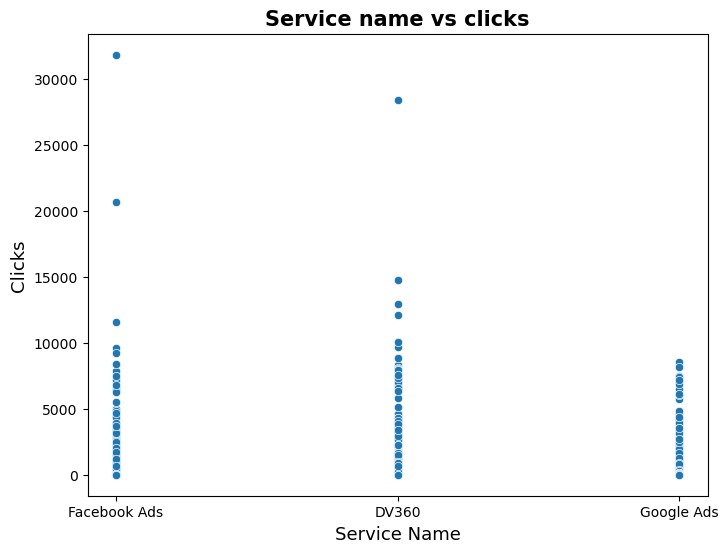

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="ext_service_name", y="clicks", data=train_df)

plt.xlabel("Service Name", size=13)
plt.ylabel("Clicks", size=13)
plt.title("Service name vs clicks", size=15, weight="bold")

Text(0.5, 1.0, 'Channel name vs clicks')

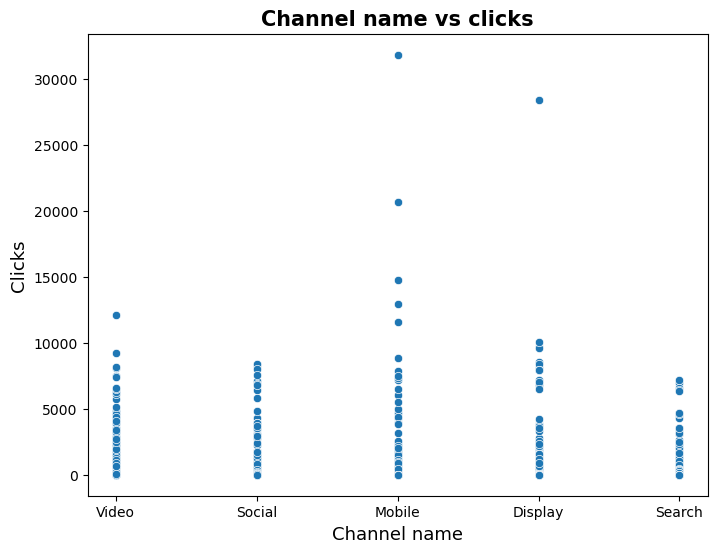

In [11]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="channel_name", y="clicks", data=train_df)

plt.xlabel("Channel name", size=13)
plt.ylabel("Clicks", size=13)
plt.title("Channel name vs clicks", size=15, weight="bold")

## Preprocessing

Data preprocessing involved handling missing values and splitting the dataset into training and testing sets. Feature engineering was also undertaken, categorizing the data into numerical and categorical features and applying transformations like standard scaling and one-hot encoding. These steps were crucial in preparing the dataset for effective modeling and ensuring that the subsequent models could interpret the features correctly.

In [12]:
train_df["creative_width"].fillna(train_df["creative_width"].mean(), inplace=True)
train_df["creative_height"].fillna(train_df["creative_height"].mean(), inplace=True)
train_df["approved_budget"].fillna(train_df["approved_budget"].mean(), inplace=True)
test_df["creative_width"].fillna(test_df["creative_width"].mean(), inplace=True)
test_df["creative_height"].fillna(test_df["creative_height"].mean(), inplace=True)
test_df["approved_budget"].fillna(test_df["approved_budget"].mean(), inplace=True)


X_train = train_df.drop(columns=["clicks"])
y_train = train_df["clicks"]
X_test = test_df.drop(columns=["clicks"])
y_test = test_df["clicks"]


categorical_features = [
    "ext_service_name",
    "search_tags",
    "advertiser_name",
    "channel_name",
    "search_tag_cat",
    "keywords",
    "campaign_item_id",
    "creative_id",
    "template_id",
    "landing_page",
    "network_id",
]


numeric_features = [
    "no_of_days",
    "creative_width",
    "creative_height",
    "approved_budget",
    "campaign_budget_usd",
    "impressions",
    "media_cost_usd",
]


drop_features = [
    "timezone",
    "weekday_cat",
    "time",
    "ext_service_id",
    "advertiser_id",
    "channel_id",
    "max_bid_cpm",
    "network_margin",
    "advertiser_currency",
    "currency_code",
    "exchange_rate",
    "stats_currency",
    "position_in_content",
    "unique_reach",
    "total_reach",
    "cmi_currency_code",
]

In [13]:
numeric_transformer = make_pipeline(StandardScaler())

categorical_transformer = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse_output=False)
)

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
    ("drop", drop_features),
)

## Baseline model and Linear model

In [14]:
# 1. dummy model
pipe_dummy = make_pipeline(preprocessor, DummyRegressor())

cv_df = pd.DataFrame(
    cross_validate(pipe_dummy, X_train, y_train, return_train_score=True, scoring="r2")
)
cv_df

,fit_time,score_time,test_score,train_score
0,0.338849,0.050295,-1.739782e-04,0.0
1,0.204633,0.048954,-3.511836e-05,0.0
2,0.204742,0.048523,-7.713505e-09,0.0
3,0.203005,0.049703,-2.369271e-05,0.0
4,0.204273,0.048488,-4.236760e-04,0.0


In [15]:
# 2. Linear Model
pipe_ridge = make_pipeline(preprocessor, Ridge())

cv_df = pd.DataFrame(
    cross_validate(
        pipe_ridge, X_train, y_train, scoring="r2", return_train_score=True, cv=10
    )
)
cv_df

cross_val_results = {}
cross_val_results["ridge"] = cv_df.agg(["mean", "std"]).round(3).T
cross_val_results["ridge"]

,mean,std
fit_time,2.600,0.043
score_time,0.026,0.003
test_score,0.552,0.194
train_score,0.574,0.025


In [16]:
# 2.1. Hyperparameter tuning

param_dist = {"ridge__alpha": 10.0 ** np.arange(-5, 5)}

random_search = RandomizedSearchCV(
    pipe_ridge,
    param_dist,
    n_iter=100,
    return_train_score=True,
    random_state=123,
    n_jobs=-1,
    scoring="r2",
    cv=5,
)

random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('pipeline-1',
                                                                               Pipeline(steps=[('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['no_of_days',
                                                                                'creative_width',
                                                                                'creative_height',
                                                                                'approved_budget',
                                                                                'campaign_budget_usd',
                                                                                'impressions',
                                                                                'media_cost_usd']),
                                                                              ('pipeline-2',
                                                                               Pipeline(steps=[('onehotencoder',
                                                                                                OneHotEnco...
                                                                                'advertiser_currency',
                                                                                'currency_code',
                                                                                'exchange_rate',
                                                                                'stats_currency',
                                                                                'position_in_content',
                                                                                'unique_reach',
                                                                                'total_reach',
                                                                                'cmi_currency_code'])])),
                                             ('ridge', Ridge())]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'ridge__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04])},
                   random_state=123, return_train_score=True, scoring='r2')

In [17]:
best_params = random_search.best_params_
best_r2 = random_search.best_score_

print("Best alpha:", best_params)
print("best score:", best_r2)

Best alpha: {'ridge__alpha': 1.0}
best score: 0.5610128732761286


## Different models

Several machine learning models, including Ridge Regression, RandomForest, and XGBoost, were trained on the preprocessed data. The models were evaluated using cross-validation to ensure their generalizability. Key performance metrics were gathered to compare these models, and hyperparameter tuning was performed to optimize their performance. The analysis provided insights into which models performed best and how different features influenced the effectiveness of the marketing campaigns.

### Randomforest Regressor

In [18]:
pipe_rf = make_pipeline(
    preprocessor, RandomForestRegressor(max_depth=10, random_state=123)
)

cv_rf = pd.DataFrame(
    cross_validate(pipe_rf, X_train, y_train, cv=5, return_train_score=True)
)
cv_rf

,fit_time,score_time,test_score,train_score
0,234.894922,0.097001,0.847762,0.907148
1,233.392853,0.098413,0.423245,0.902376
2,231.588918,0.097650,0.677637,0.919840
3,233.910758,0.101407,0.627791,0.931317
4,235.108077,0.098503,0.690671,0.935679


In [19]:
cross_val_results["randomforest"] = cv_rf.agg(["mean", "std"]).round(3).T
cross_val_results["randomforest"]

,mean,std
fit_time,233.779,1.412
score_time,0.099,0.002
test_score,0.653,0.153
train_score,0.919,0.015


In [20]:
pipe_rf.fit(X_train, y_train)
model_rf = pipe_rf.named_steps["randomforestregressor"]

In [21]:
feature_importances_rf = model_rf.feature_importances_
feature_names_1 = (
    pipe_rf.named_steps["columntransformer"]
    .named_transformers_["pipeline-1"]
    .get_feature_names_out()
    .tolist()
)
feature_names_2 = (
    pipe_rf.named_steps["columntransformer"]
    .named_transformers_["pipeline-2"]
    .get_feature_names_out()
    .tolist()
)

feature_names = feature_names_1 + feature_names_2
feature_importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances_rf}
)
feature_importances_rf_sorted = feature_importance_df.sort_values(
    by="Importance", ascending=False
).head(10)
feature_importances_rf_sorted

,Feature,Importance
5,impressions,0.403872
0,no_of_days,0.095226
4,campaign_budget_usd,0.071768
779,creative_id_3200,0.060265
6,media_cost_usd,0.060028
122,keywords_fall jewelry,0.056097
2942,creative_id_14240,0.037021
74,keywords_animal jewelry,0.031342
2971,creative_id_14395,0.016474
61,channel_name_Mobile,0.011151


### XGBoost Regressor

In [22]:
pipe_xgb = make_pipeline(preprocessor, XGBRegressor(random_state=123, verbosity=0))
cv_df_xg = pd.DataFrame(
    cross_validate(pipe_xgb, X_train, y_train, cv=5, return_train_score=True)
)
cv_df_xg

,fit_time,score_time,test_score,train_score
0,2.522942,0.078481,0.666278,0.990936
1,2.691893,0.081887,0.650943,0.990242
2,2.822037,0.077023,0.829305,0.990621
3,2.827474,0.079427,0.686114,0.992725
4,2.924998,0.082253,0.712322,0.993794


In [23]:
cross_val_results["XGBoost"] = cv_df_xg.agg(["mean", "std"]).round(3).T
cross_val_results["XGBoost"]

,mean,std
fit_time,2.758,0.155
score_time,0.080,0.002
test_score,0.709,0.071
train_score,0.992,0.002


In [24]:
pipe_xgb.fit(X_train, y_train)
model_xg = pipe_xgb.named_steps["xgbregressor"]

In [25]:
feature_importances_xgb = model_xg.feature_importances_
feature_importances_xgb
feature_names_1 = (
    pipe_xgb.named_steps["columntransformer"]
    .named_transformers_["pipeline-1"]
    .get_feature_names_out()
    .tolist()
)
feature_names_2 = (
    pipe_xgb.named_steps["columntransformer"]
    .named_transformers_["pipeline-2"]
    .get_feature_names_out()
    .tolist()
)

feature_names_xgb = feature_names_1 + feature_names_2
feature_importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances_xgb}
)
feature_importances_xgb_sorted = feature_importance_df.sort_values(
    by="Importance", ascending=False
).head(10)
feature_importances_xgb_sorted

,Feature,Importance
779,creative_id_3200,0.189142
214,campaign_item_id_3050,0.084807
2942,creative_id_14240,0.059644
2951,creative_id_14290,0.054971
4,campaign_budget_usd,0.043029
218,campaign_item_id_3054,0.040848
39,advertiser_name_Maharashtra,0.038523
236,campaign_item_id_3131,0.038000
2971,creative_id_14395,0.032447
5,impressions,0.028444


### LGBM Regressor

In [26]:
pipe_lgbm = make_pipeline(preprocessor, LGBMRegressor(random_state=123))
cv_df_lgbm = pd.DataFrame(
    cross_validate(pipe_lgbm, X_train, y_train, cv=5, return_train_score=True)
)
cv_df_lgbm

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3035
[LightGBM] [Info] Number of data points in the train set: 34853, number of used features: 1047
[LightGBM] [Info] Start training from score 51.146788
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3007
[LightGBM] [Info] Number of data points in the train set: 34853, number of used features: 1033
[LightGBM] [Info] Start training from score 51.508507
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001342 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not

,fit_time,score_time,test_score,train_score
0,0.839998,0.068989,0.786958,0.753194
1,0.793854,0.069667,0.514754,0.782099
2,0.777326,0.068128,0.590251,0.799245
3,0.807057,0.069114,0.722192,0.772370
4,0.790798,0.066359,0.717212,0.779497


In [27]:
cross_val_results["LGBMRegressor"] = cv_df_lgbm.agg(["mean", "std"]).round(3).T
cross_val_results["LGBMRegressor"]

,mean,std
fit_time,0.802,0.024
score_time,0.068,0.001
test_score,0.666,0.111
train_score,0.777,0.017


In [28]:
pipe_lgbm.fit(X_train, y_train)
model_lgbm = pipe_lgbm.named_steps["lgbmregressor"]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3530
[LightGBM] [Info] Number of data points in the train set: 43567, number of used features: 1295
[LightGBM] [Info] Start training from score 52.098676


In [29]:
feature_importances_lgbm = model_lgbm.feature_importances_
feature_names_1 = (
    pipe_lgbm.named_steps["columntransformer"]
    .named_transformers_["pipeline-1"]
    .get_feature_names_out()
    .tolist()
)
feature_names_2 = (
    pipe_lgbm.named_steps["columntransformer"]
    .named_transformers_["pipeline-2"]
    .get_feature_names_out()
    .tolist()
)

feature_names = feature_names_1 + feature_names_2
feature_importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances_lgbm}
)
feature_importances_lgbm_sorted = feature_importance_df.sort_values(
    by="Importance", ascending=False
).head(10)
feature_importances_lgbm_sorted

,Feature,Importance
0,no_of_days,542
4,campaign_budget_usd,499
5,impressions,471
3,approved_budget,269
6,media_cost_usd,197
40,advertiser_name_Malad,73
1,creative_width,66
218,campaign_item_id_3054,48
226,campaign_item_id_3101,43
34,advertiser_name_Karnataka,37


In [30]:
pd.concat(cross_val_results, axis=1)

ridge        randomforest        XGBoost        LGBMRegressor  \
              mean    std         mean    std    mean    std          mean   
fit_time     2.600  0.043      233.779  1.412   2.758  0.155         0.802   
score_time   0.026  0.003        0.099  0.002   0.080  0.002         0.068   
test_score   0.552  0.194        0.653  0.153   0.709  0.071         0.666   
train_score  0.574  0.025        0.919  0.015   0.992  0.002         0.777   

                    
               std  
fit_time     0.024  
score_time   0.001  
test_score   0.111  
train_score  0.017

### Hyperparameter optimization (XGBOOT Regressor)

In [31]:
param_dist = {
    "xgbregressor__n_estimators": randint(50, 150),
    "xgbregressor__max_depth": randint(3, 7),
    "xgbregressor__learning_rate": uniform(0.01, 0.1),
    "xgbregressor__subsample": uniform(0.5, 0.5),
    "xgbregressor__colsample_bytree": uniform(0.5, 0.5),
    "xgbregressor__min_child_weight": randint(1, 6),
    "xgbregressor__gamma": uniform(0, 0.5),
    "xgbregressor__reg_alpha": uniform(0, 1),
    "xgbregressor__reg_lambda": uniform(1, 3),
}

random_search = RandomizedSearchCV(
    pipe_xgb,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring="r2",
    random_state=123,
    verbose=1,
)


random_search.fit(X_train, y_train)

best_params = random_search.best_params_

print("Best parameters:", best_params)

best_model = random_search.best_estimator_

cv_df_xg_t = pd.DataFrame(
    cross_validate(best_model, X_train, y_train, cv=5, return_train_score=True)
)
print(cv_df_xg_t)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'xgbregressor__colsample_bytree': 0.6520603945135921, 'xgbregressor__gamma': 0.2085111055123508, 'xgbregressor__learning_rate': 0.07813007657927966, 'xgbregressor__max_depth': 6, 'xgbregressor__min_child_weight': 2, 'xgbregressor__n_estimators': 148, 'xgbregressor__reg_alpha': 0.5859365525622129, 'xgbregressor__reg_lambda': 2.8747105062867995, 'xgbregressor__subsample': 0.8373445254939125}
   fit_time  score_time  test_score  train_score
0  5.603800    0.112642    0.817036     0.949060
1  5.382053    0.120870    0.778834     0.943036
2  5.394666    0.185935    0.837837     0.946733
3  5.302368    0.116548    0.712925     0.959659
4  5.664001    0.113574    0.749796     0.960564


In [32]:
cross_val_results["XGBoost-optimized"] = cv_df_xg_t.agg(["mean", "std"]).round(3).T
cross_val_results["XGBoost-optimized"]

,mean,std
fit_time,5.469,0.156
score_time,0.130,0.031
test_score,0.779,0.050
train_score,0.952,0.008


### Hyperparameter optimization and feature selection with Ridge

In [33]:
pipe_xgb_ridge = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("feature_selector", SelectFromModel(Ridge())),
        ("xgbregressor", XGBRegressor(random_state=123, verbosity=0)),
    ]
)


param_dist_ridge = {
    "feature_selector__estimator__alpha": uniform(1, 100),
    "feature_selector__threshold": ["mean", "median", "1.25*mean", "2*mean"],
    "xgbregressor__n_estimators": [50, 100, 150],
    "xgbregressor__max_depth": [3, 4],
    "xgbregressor__learning_rate": [0.01, 0.05],
    "xgbregressor__subsample": [0.7, 0.8],  
    "xgbregressor__colsample_bytree": [0.7, 0.8],
    "xgbregressor__min_child_weight": [3, 4, 5],
    "xgbregressor__gamma": [0.1, 0.2, 0.3],
    "xgbregressor__reg_alpha": [0.5, 1, 1.5],  
    "xgbregressor__reg_lambda": [1, 2, 3],  
}


random_search_ridge = RandomizedSearchCV(
    estimator=pipe_xgb_ridge,
    param_distributions=param_dist_ridge,
    n_iter=50,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    random_state=123,
    verbose=1,
)


random_search_ridge.fit(X_train, y_train)


best_params_ridge = random_search_ridge.best_params_
best_model_ridge = random_search_ridge.best_estimator_


cv_df_xg_ridge = pd.DataFrame(
    cross_validate(
        best_model_ridge, X_train, y_train, cv=5, return_train_score=True, n_jobs=-1
    )
)
print(cv_df_xg_ridge)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
    fit_time  score_time  test_score  train_score
0  32.462830    0.343610    0.817020     0.785989
1  32.979299    0.399437    0.680431     0.797757
2  33.148423    0.512804    0.671717     0.790713
3  33.170786    0.516436    0.612286     0.837520
4  33.130382    0.516661    0.698125     0.825361


In [34]:
cross_val_results["XGBoost-optimized-normalized-ridge-select"] = (
    cv_df_xg_ridge.agg(["mean", "std"]).round(3).T
)
cross_val_results["XGBoost-optimized-normalized-ridge-select"]

,mean,std
fit_time,32.978,0.298
score_time,0.458,0.081
test_score,0.696,0.075
train_score,0.807,0.023


### features selection with RFECV

In [35]:
# rfecv = RFECV(Ridge(), n_jobs=-1)

# pipe_rf_rfecv = make_pipeline(
#     preprocessor, rfecv, XGBRegressor(random_state=123)
# )
# cv_df_rfecv = pd.DataFrame(cross_validate(pipe_rf_rfecv, X_train, y_train,cv = 5, return_train_score = True))

In [36]:
# rfecv_fs = pipe_rf_rfecv.named_steps["rfecv"]
# rfecv_fs.n_features_

In [37]:
# cross_val_results['RFECV'] = cv_df_rfecv.agg(['mean', 'std']).round(3).T
# cross_val_results['RFECV']

In [38]:
pd.concat(cross_val_results, axis = 1)

ridge        randomforest        XGBoost        LGBMRegressor  \
              mean    std         mean    std    mean    std          mean   
fit_time     2.600  0.043      233.779  1.412   2.758  0.155         0.802   
score_time   0.026  0.003        0.099  0.002   0.080  0.002         0.068   
test_score   0.552  0.194        0.653  0.153   0.709  0.071         0.666   
train_score  0.574  0.025        0.919  0.015   0.992  0.002         0.777   

                   XGBoost-optimized         \
               std              mean    std   
fit_time     0.024             5.469  0.156   
score_time   0.001             0.130  0.031   
test_score   0.111             0.779  0.050   
train_score  0.017             0.952  0.008   

            XGBoost-optimized-normalized-ridge-select         
                                                 mean    std  
fit_time                                       32.978  0.298  
score_time                                      0.458  0.081  
test_score                                      0.696  0.075  
train_score                                     0.807  0.023

### Interpretation and feature importances

In [39]:
feature_importances_xgb_sorted

,Feature,Importance
779,creative_id_3200,0.189142
214,campaign_item_id_3050,0.084807
2942,creative_id_14240,0.059644
2951,creative_id_14290,0.054971
4,campaign_budget_usd,0.043029
218,campaign_item_id_3054,0.040848
39,advertiser_name_Maharashtra,0.038523
236,campaign_item_id_3131,0.038000
2971,creative_id_14395,0.032447
5,impressions,0.028444


In [40]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names_xgb,
    index=X_test.index,
)
X_test_enc

,no_of_days,creative_width,creative_height,approved_budget,campaign_budget_usd,impressions,media_cost_usd,ext_service_name_DV360,ext_service_name_Facebook Ads,ext_service_name_Google Ads,...,landing_page_https://www.abcjewelry.com/women/statement-jewelry/,landing_page_https://www.abcjewelry.com/women/trendy-jewelry/,landing_page_https://www.abcjewelry.com/women/unique-jewelry/,landing_page_https://www.abcjewelry.com/women/vintage-inspired-jewelry/,network_id_188,network_id_190,network_id_191,network_id_287,network_id_350,network_id_353
5047,2.301549,-2.953492,-2.953492,-0.186138,-0.214536,-0.184391,-0.124809,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8622,2.262457,0.355395,0.355395,-0.207569,-0.067288,-0.215877,-0.213879,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
50081,-0.395806,0.355395,0.355395,-0.216499,-0.442321,-0.218523,-0.231135,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1817,3.435220,-2.953492,-2.953492,-0.223643,0.136013,-0.221169,-0.224907,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
61515,-0.513082,0.355395,0.355395,-0.210248,-0.251688,-0.208469,-0.222088,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17065,-0.904003,0.355395,0.355395,1.390825,-0.270621,0.105331,0.020293,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
72506,-0.395806,0.000897,0.000897,0.217755,-0.273349,0.039978,-0.026321,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22582,-0.356714,0.355395,0.355395,0.515726,-0.105233,0.613601,0.267537,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
61560,-0.043977,0.355395,0.355395,-0.210248,-0.403712,-0.218258,-0.230116,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [57]:
xgbr_explainer = shap.TreeExplainer(best_model.named_steps["xgbregressor"])
xgbr_explanation = xgbr_explainer(X_test_enc)
xgbr_explanation.shape

(29045, 3222)

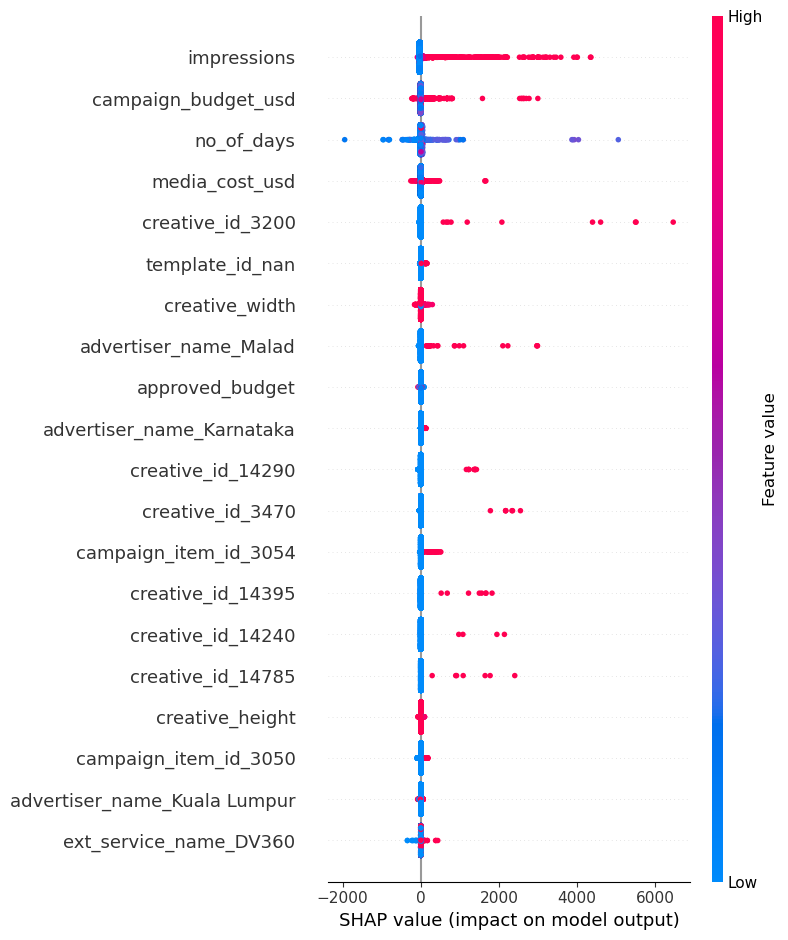

In [58]:
xgbr_model = best_model.named_steps["xgbregressor"]
explainer = shap.TreeExplainer(xgbr_model)
shap_values = explainer.shap_values(X_test_enc)
shap.summary_plot(shap_values, X_test_enc)

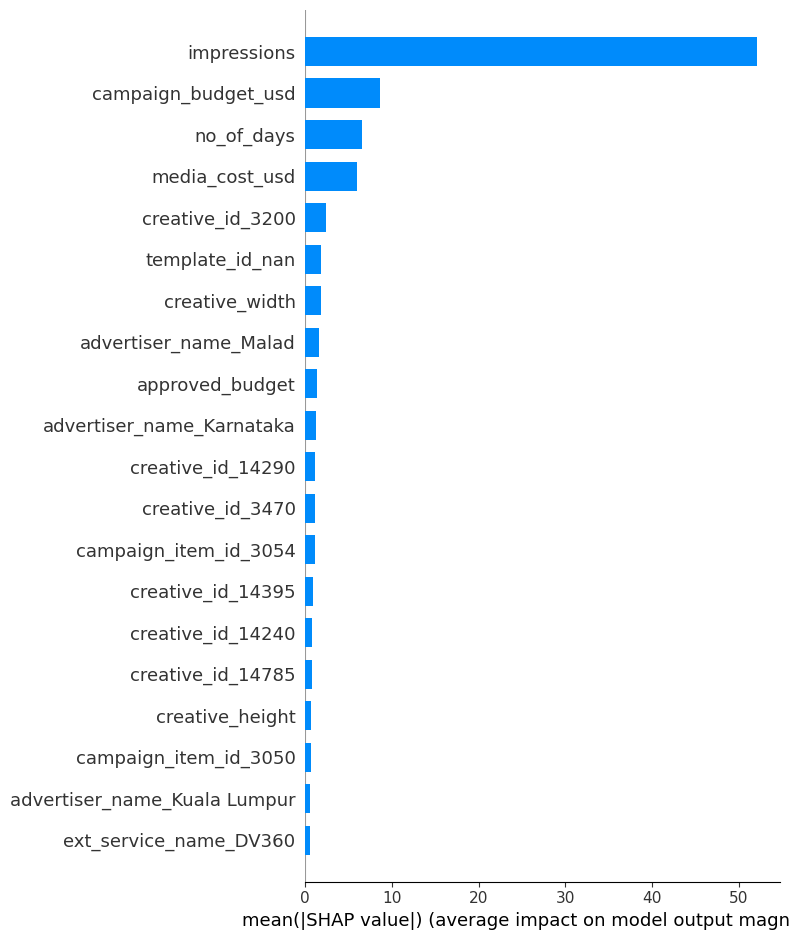

In [59]:
shap.summary_plot(shap_values, X_test_enc, plot_type="bar")

In [44]:
# result on the test set
best_score = random_search.best_score_
round(best_score, 2)

0.78

In [45]:
# shap value
y_test_reset = y_test.reset_index(drop=True)
y_test_reset

0          9
1          6
2          5
3         10
4         12
        ... 
29040     59
29041     52
29042    108
29043     11
29044     21
Name: clicks, Length: 29045, dtype: int64

In [46]:
y_test_reset.mean()

53.59294198657256

In [47]:
less_ind = y_test_reset[y_test_reset <= 53].index.tolist()
gr_ind = y_test_reset[y_test_reset > 53].index.tolist()

ex_less_ind = less_ind[1000]
ex_gr_ind = gr_ind[1000]

In [60]:
best_model.named_steps["xgbregressor"].predict(X_test_enc)[ex_less_ind]

7.3257475

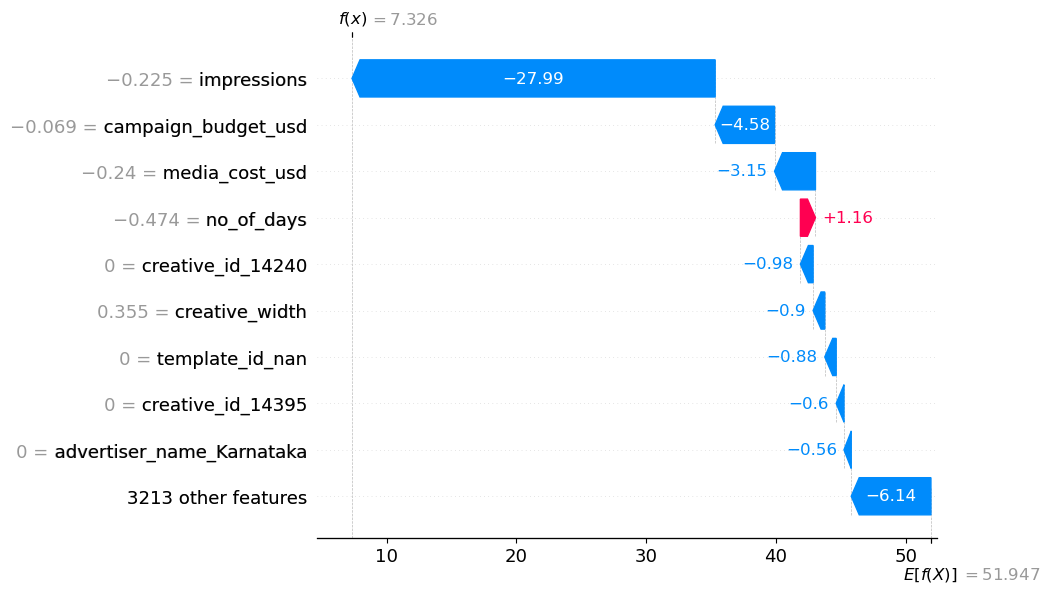

In [61]:
shap.plots.waterfall(xgbr_explanation[ex_less_ind])

In [62]:
explainer = shap.TreeExplainer(xgbr_model)
shap_values = explainer.shap_values(X_test_enc)
shap_df_ex_less_ind = pd.DataFrame(
    shap_values[ex_less_ind], index=feature_names, columns=["SHAP values"]
).sort_values("SHAP values")
shap_df_ex_less_ind

,SHAP values
impressions,-27.990145
campaign_budget_usd,-4.575463
media_cost_usd,-3.154389
creative_id_14240,-0.979186
creative_width,-0.899043
...,...
creative_id_4325,0.051633
creative_id_14225,0.081630
channel_name_Social,0.102587
advertiser_name_Kuala Lumpur,0.124145


In [63]:
best_model.named_steps["xgbregressor"].predict(X_test_enc)[ex_gr_ind]

93.43962

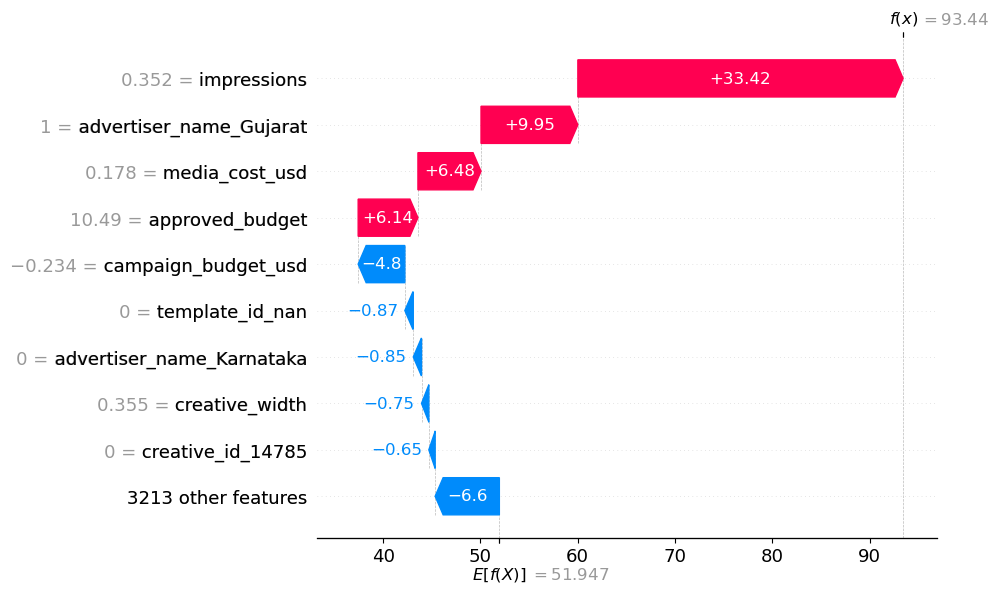

In [64]:
shap.plots.waterfall(xgbr_explanation[ex_gr_ind])

In [65]:
shap_df_ex_gr_ind = pd.DataFrame(
    shap_values[ex_gr_ind], index=feature_names, columns=["SHAP values"]
).sort_values("SHAP values")
shap_df_ex_gr_ind

,SHAP values
campaign_budget_usd,-4.797534
template_id_nan,-0.866670
advertiser_name_Karnataka,-0.846567
creative_width,-0.751019
creative_id_14785,-0.650714
...,...
template_id_90.0,0.647410
approved_budget,6.142859
media_cost_usd,6.482775
advertiser_name_Gujarat,9.952392


## Conclusion

The analysis revealed that certain features like audience demographics, campaign type, and ad impressions significantly influenced the campaign outcomes. The machine learning models, especially RandomForest, provided deeper insights into how these features impacted the success rates of campaigns. The feature importance plots emphasized the dominance of impressions in predicting user engagement.

Among the various models evaluated, RandomForest and XGBoost stood out in terms of accuracy and precision. The concluding section synthesized the findings, suggesting that a strategic focus on optimizing high-impact features could enhance campaign effectiveness. The data-driven insights provided a foundation for refining marketing strategies, particularly in targeting and ad design. These results not only highlighted the potential of data analytics in marketing but also outlined actionable steps for future campaigns.

## References